In [1]:
!pip install -q opencv-python numpy matplotlib


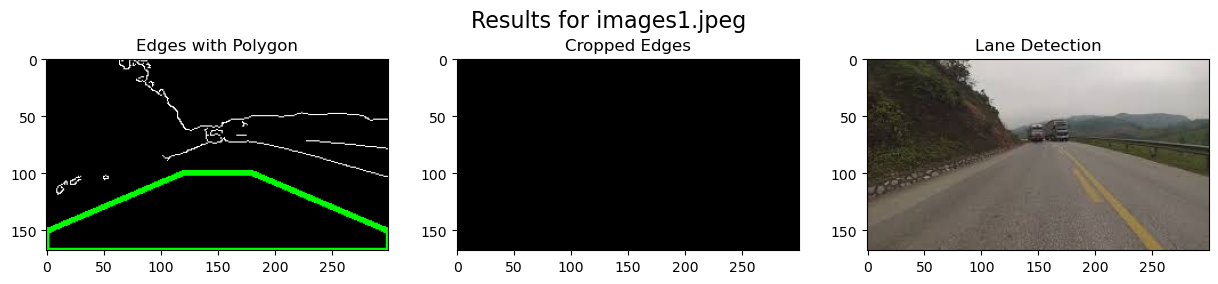

Command for images1.jpeg: No lanes detected


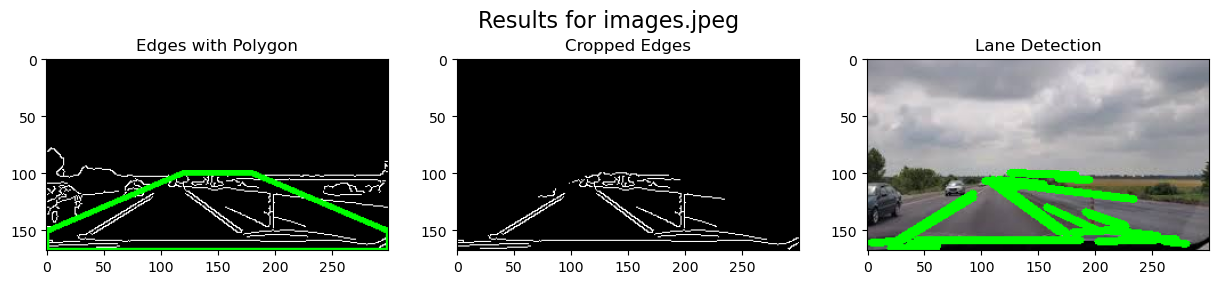

Command for images.jpeg: Move Left
Lane Center: 114.33333333333334, Car Position: 150.0


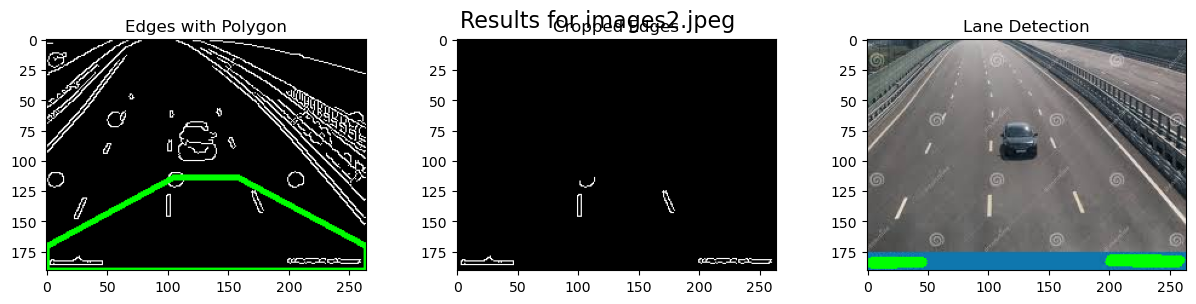

Command for images2.jpeg: No clear direction


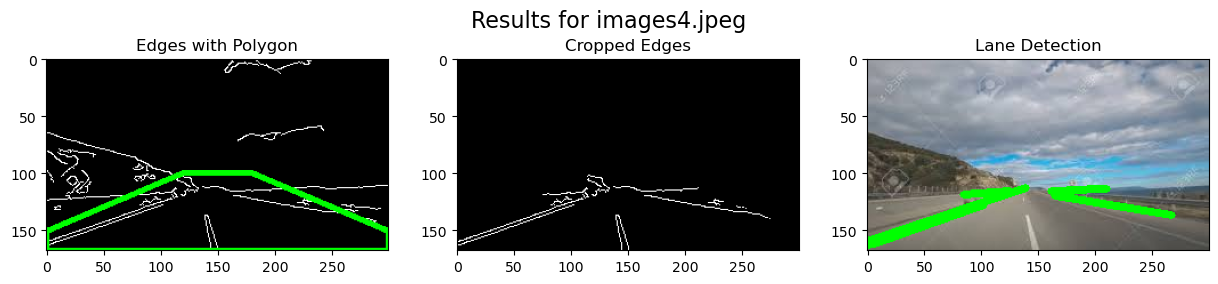

Command for images4.jpeg: Move Left
Lane Center: 108.6, Car Position: 150.0


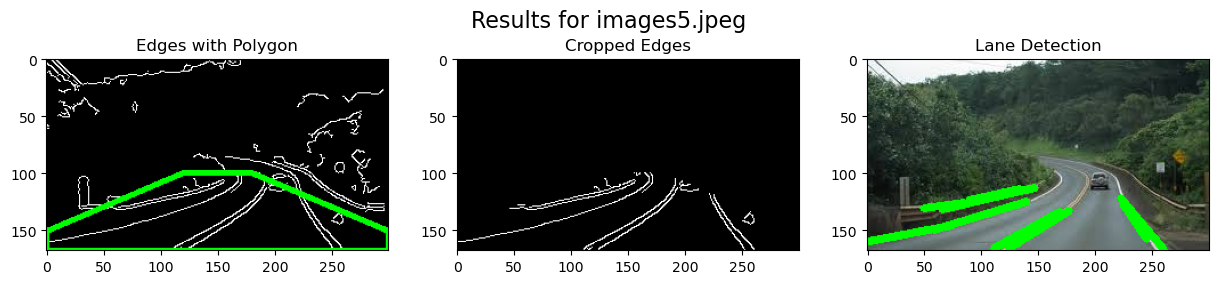

Command for images5.jpeg: Forward
Lane Center: 147.0, Car Position: 150.0


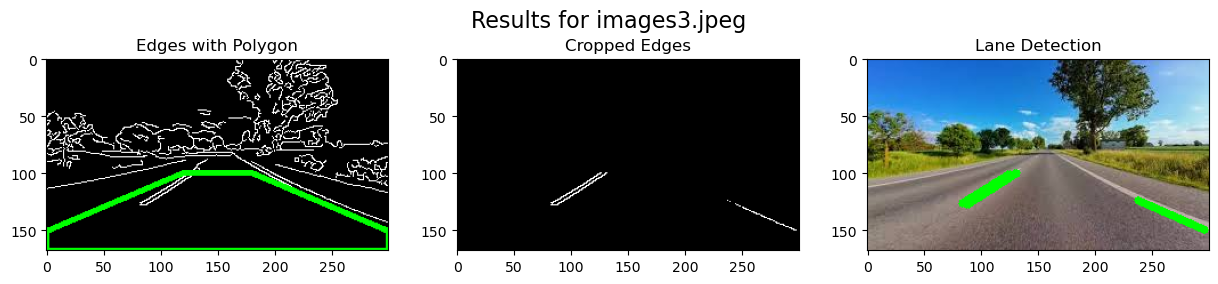

Command for images3.jpeg: Move Right
Lane Center: 161.0, Car Position: 150.0


In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os

# Function to process the frame and detect lane lines
def process_frame(frame):
    # Convert to grayscale
    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    
    # Apply Gaussian Blur to reduce noise
    blurred = cv2.GaussianBlur(gray, (5, 5), 0)
    
    # Apply Canny edge detection
    edges = cv2.Canny(blurred, 60, 150)
    
    # Define a region of interest (ROI)
    height, width = edges.shape
    polygon = np.array([[
        (int(width * 0), int(height * 0.9)),
        (int(width * 0), height),
        (int(width * 1), height),
        (int(width * 1), int(height * 0.9)),
        (int(width * 0.6), int(height * 0.6)),
        (int(width * 0.4), int(height * 0.6))
    ]], np.int32)
    
    mask = np.zeros_like(edges)
    cv2.fillPoly(mask, polygon, 255)
    cropped_edges = cv2.bitwise_and(edges, mask)
    
    # Use Hough Transform to detect lines
    lines = cv2.HoughLinesP(cropped_edges, 1, np.pi / 180, 30, minLineLength=20, maxLineGap=10)
    
    return lines, edges, cropped_edges, polygon

# Function to determine movement commands based on lane lines
def determine_movement(lines, frame_width):
    if lines is None:
        return "No lanes detected", None
    
    # Separate lines into left and right
    left_lines = []
    right_lines = []
    for line in lines:
        x1, y1, x2, y2 = line[0]
        slope = (y2 - y1) / (x2 - x1) if x2 - x1 != 0 else np.inf
        if slope < 0:  # Left line
            left_lines.append(line)
        elif slope > 0:  # Right line
            right_lines.append(line)
    
    # Calculate the average position of the lanes
    left_line_x = np.mean([line[0][0] for line in left_lines]) if left_lines else None
    right_line_x = np.mean([line[0][0] for line in right_lines]) if right_lines else None
    
    # Determine the car's position relative to the lane center
    if left_line_x and right_line_x:
        lane_center = (left_line_x + right_line_x) / 2
        car_position = frame_width / 2
        if car_position < lane_center - 10:
            return "Move Right", (lane_center, car_position)
        elif car_position > lane_center + 10:
            return "Move Left", (lane_center, car_position)
        else:
            return "Forward", (lane_center, car_position)
    return "No clear direction", None

# Process all .jpeg images in the current directory
image_files = [file for file in os.listdir('.') if file.endswith('.jpeg')]

for image_file in image_files:
    frame = cv2.imread(image_file)
    if frame is None:
        print(f"Error: Could not load {image_file}")
        continue
    
    lines, edges, cropped_edges, polygon = process_frame(frame)
    command, info = determine_movement(lines, frame.shape[1])
    
    # Display results
    plt.figure(figsize=(15, 3))
    plt.suptitle(f"Results for {image_file}", fontsize=16)
    
    plt.subplot(1, 3, 1)
    plt.title("Edges with Polygon")
    edges_with_polygon = cv2.cvtColor(edges, cv2.COLOR_GRAY2BGR)
    cv2.polylines(edges_with_polygon, polygon, isClosed=True, color=(0, 255, 0), thickness=3)
    plt.imshow(cv2.cvtColor(edges_with_polygon, cv2.COLOR_BGR2RGB))
    
    plt.subplot(1, 3, 2)
    plt.title("Cropped Edges")
    plt.imshow(cropped_edges, cmap='gray')
    
    plt.subplot(1, 3, 3)
    plt.title("Lane Detection")
    output_frame = frame.copy()
    if lines is not None:
        for line in lines:
            x1, y1, x2, y2 = line[0]
            cv2.line(output_frame, (x1, y1), (x2, y2), (0, 255, 0), 5)
    plt.imshow(cv2.cvtColor(output_frame, cv2.COLOR_BGR2RGB))
    
    plt.show()
    
    # Print command for the current image
    print(f"Command for {image_file}: {command}")
    if info:
        print(f"Lane Center: {info[0]}, Car Position: {info[1]}")
